# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de Tenerife

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def estudio_STL(df):
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()
    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))
    plt.title('STL')
        
    plt.xticks(rotation=90)
    
    plt.show()
    
def realizar_diferenciacion(df, variable, n_diff):
    for i in range(0, n_diff):
        df[variable] = df[variable].diff().dropna()
    
    return df
    
    
def visualizar_diferencia(df):

    plt.figure(figsize=(10, 6))
    plt.plot(df['fecha'], df['numero_casos'])
    plt.title('Transformación por diferencia de la serie temporal')
    plt.xlabel('Fecha')
    plt.ylabel('Diferencia')
    
    
    plt.show()
    
def visualizar_acf(df, variable, n_lags):
    plt.figure(figsize=(16, 10))
    plot_acf(df[variable], lags=n_lags)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.show()
    
def visualizar_pacf(df, variable, n_lags):
    plt.figure(figsize=(16, 6))
    plot_pacf(df[variable], lags=n_lags)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    plt.figure(figsize=(10, 6))

    plt.plot(test.index, test[variable], label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')


    plt.xticks(rotation=90)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_errores(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    return mae, mse


    
def winsorizacion(df, variable):
    
    percentil_5 = df[variable].quantile(0.05)
    print(percentil_5)
    percentil_95 = df[variable].quantile(0.95)
    print(percentil_95)
    
    df[variable] = np.where(df[variable] < percentil_5, percentil_5,
                               np.where(df[variable] > percentil_95, percentil_95, df[variable]))
    
    return df

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

In [4]:
datos_tenerife = datos[datos['isla'] == 'TENERIFE'].copy()
datos_tenerife_arima = datos_tenerife[['fecha', 'numero_casos']]
datos_tenerife_arima.set_index('fecha', inplace=True)

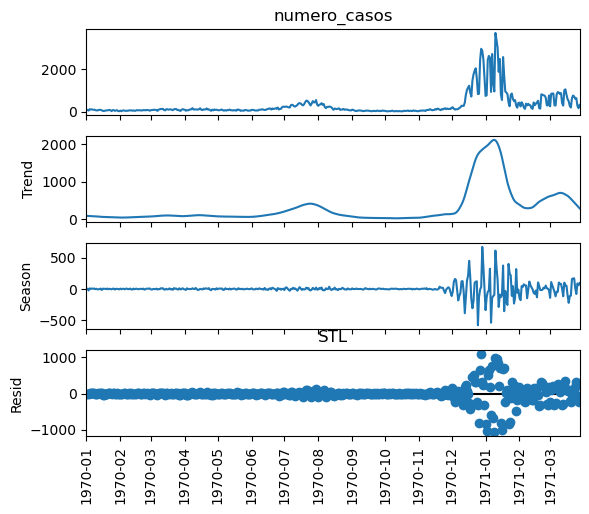

In [5]:
estudio_STL(datos_tenerife_arima['numero_casos'])

Realizamos un estudio de Dickey-Fuller para verificar si la serie temporal es estacionaria:

In [6]:
adf_tenerife = adfuller(datos_tenerife_arima['numero_casos'])
print("ADF p-value:" + str(adf_tenerife[1]))

ADF p-value:0.009618252771198928


Podemos observar que el p valor es inferior al valor de significancia 0.05 por lo que la serie temporal ya es estacionaria y por lo tanto el valor d del modelo ARIMA es 0

In [7]:
# Código para relaizar múltiples diferenciaciones
# datos_tenerife_diff = realizar_diferenciacion(datos_tenerife_diff, 'numero_casos', 2)
# visualizar_diferencia(datos_tenerife_diff)

Realizamos un análisis de la Función de autocorrelación (ACF) para medir la correlación de la serie temporal y sus valores rezagados para determinar el valor de p

<Figure size 1600x1000 with 0 Axes>

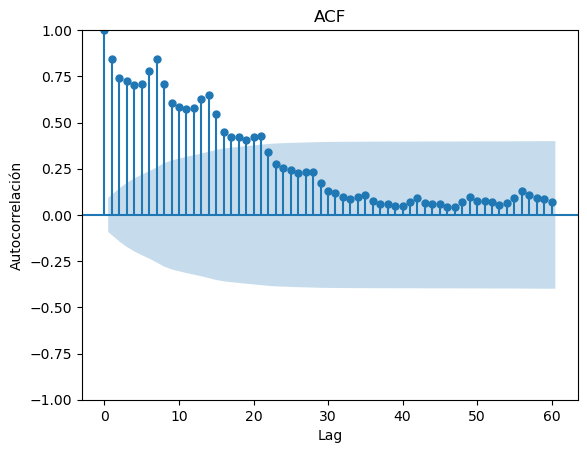

In [8]:
visualizar_acf(datos_tenerife_arima, 'numero_casos', 30)

Realizamos un análisis de la Función e Autocorrelación Parcial (PACF) para determinar el valor de q

<Figure size 1600x600 with 0 Axes>

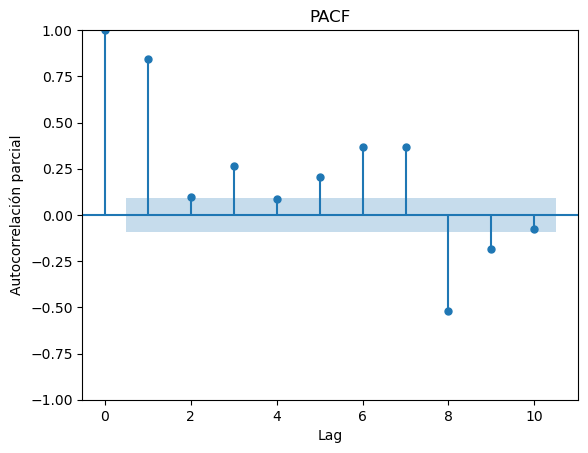

In [9]:
visualizar_pacf(datos_tenerife_arima, 'numero_casos', 10)

# Modelo ARIMA univariable

In [10]:
datos_arima_tenerife = datos_tenerife_arima.copy()

n_dias = 10

train = datos_arima_tenerife.iloc[:len(datos_arima_tenerife) - n_dias]
test =  datos_arima_tenerife.iloc[len(datos_arima_tenerife) - n_dias:]

objetivo = 'numero_casos'

In [11]:
#order=(p,d,q)
# Parámetros del modelo ARIMA
p = 18
d = 0
q = 3

arima_tenerife = ARIMA(endog=train[objetivo], order=(p, d, q), freq = 'D')
model_arima_tenerife = arima_tenerife.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
pred = model_arima_tenerife.forecast(steps=10)

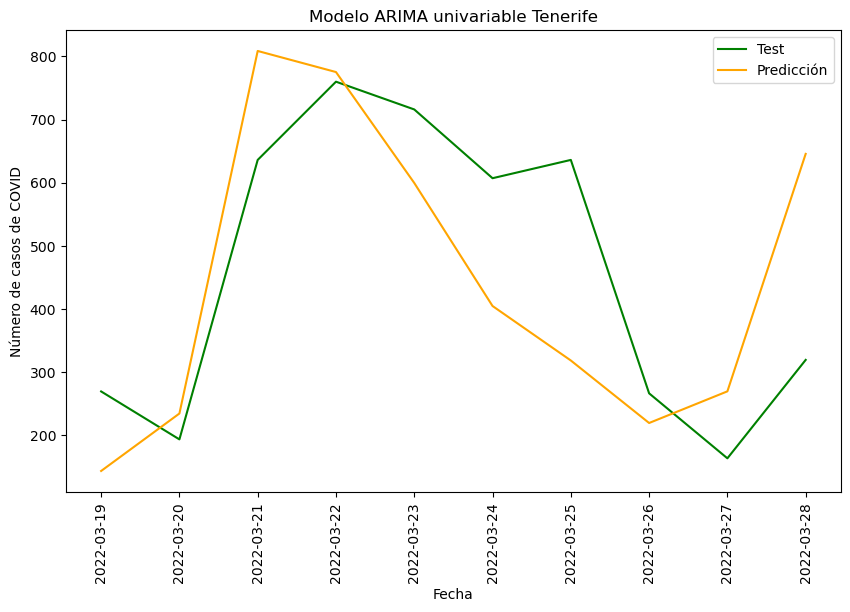

In [13]:
visualizar_dif_pred_test(test, pred, objetivo, 'Modelo ARIMA univariable Tenerife')

In [33]:
model_arima_tenerife.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           numero_casos   No. Observations:                  442
Model:                ARIMA(18, 0, 3)   Log Likelihood               -2785.586
Date:                Tue, 16 Apr 2024   AIC                           5625.171
Time:                        20:06:47   BIC                           5735.637
Sample:                    01-01-2021   HQIC                          5668.742
                         - 03-18-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.0593     89.216     -2.063      0.039    -358.919      -9.199
pcr_total      0.2246      0.007     32.123      0.000       0.211       0.238
Urg_ingr      -0.9464      0.239     -3.956      0.000      -1.415      -0.477
HPT_cv19       2.5198      0.382      6.600      0.000       1.772       3.268
CCR_cv19      -9.1163      2.806     -3.249      0.001     -14.615      -3.617
ar.L1          0.1044      0.293      0.356      0.722      -0.471       0.679
ar.L2          0.4312      0.208      2.070      0.038       0.023       0.839
ar.L3          0.8221      0.185      4.452      0.000       0.460       1.184
ar.L4         -0.3106      0.165     -1.887      0.059      -0.633       0.012
ar.L5         -0.1355      0.080     -1.695      0.090      -0.292       0.021
ar.L6         -0.0935      0.072     -1.295      0.195      -0.235       0.048
ar.L7          0.5788      0.055     10.501      0.000       0.471       0.687
ar.L8         -0.1314      0.162     -0.812      0.417      -0.449       0.186
ar.L9         -0.3643      0.140     -2.602      0.009      -0.639      -0.090
ar.L10        -0.3820      0.146     -2.622      0.009      -0.668      -0.096
ar.L11         0.2668      0.134      1.986      0.047       0.004       0.530
ar.L12         0.0466      0.105      0.444      0.657      -0.159       0.253
ar.L13         0.0936      0.088      1.063      0.288      -0.079       0.266
ar.L14        -0.0829      0.075     -1.101      0.271      -0.230       0.065
ar.L15         0.1088      0.093      1.173      0.241      -0.073       0.291
ar.L16         0.0008      0.086      0.010      0.992      -0.168       0.169
ar.L17        -0.0296      0.078     -0.379      0.704      -0.183       0.123
ar.L18        -0.1000      0.093     -1.075      0.282      -0.282       0.082
ma.L1          0.3916      0.300      1.307      0.191      -0.196       0.979
ma.L2         -0.1149      0.248     -0.463      0.643      -0.601       0.371
ma.L3         -0.6992      0.228     -3.062      0.002      -1.147      -0.252
sigma2       1.81e+04   1123.923     16.105      0.000    1.59e+04    2.03e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              4818.37
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               5.08   Skew:                             1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
mae, mse = obtener_errores(test[objetivo], pred)

In [15]:
print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))

Error cuadrático medio (MSE) del modelo: 32346.4973030589
Error absoluto medio (MAE) del modelo: 147.18822154840421


# Modelo ARIMA multivariable

In [24]:
datos_tenerife = datos[datos['isla'] == 'TENERIFE'].copy()

variables_covid = ['pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']

datos_tenerife_arima = datos_tenerife[['fecha', objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
datos_tenerife_arima.set_index('fecha', inplace=True)

In [27]:
n_dias = 10

train = datos_tenerife_arima.iloc[:len(datos_tenerife_arima) - n_dias]
test =  datos_tenerife_arima.iloc[len(datos_tenerife_arima) - n_dias:]

In [28]:
#order=(p,d,q)
# Parámetros del modelo ARIMA
p = 18
d = 0
q = 3

arima_tenerife = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
model_arima_tenerife = arima_tenerife.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
pred = model_arima_tenerife.forecast(steps=10, exog=test[variables_covid])

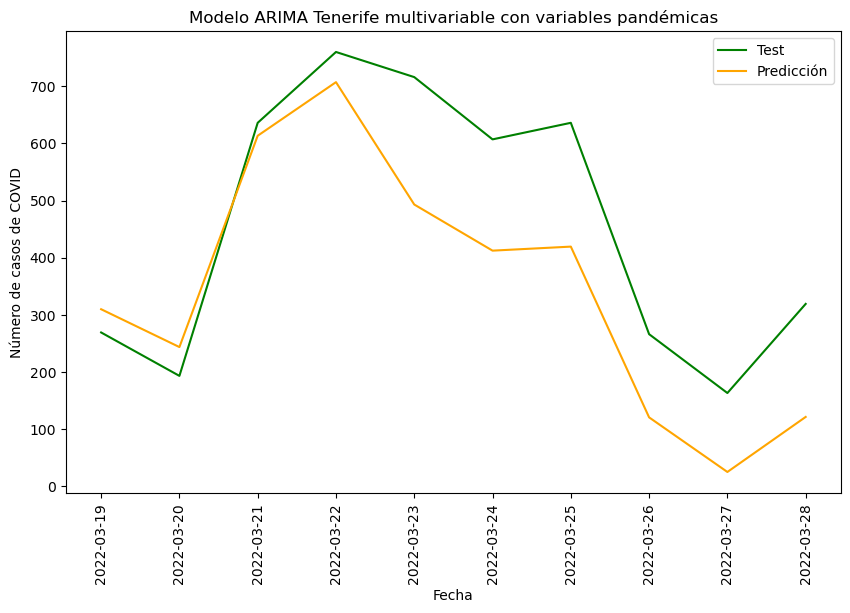

In [30]:
visualizar_dif_pred_test(test, pred, objetivo, 'Modelo ARIMA Tenerife multivariable con variables pandémicas')

In [31]:
mae, mse = obtener_errores(test[objetivo], pred)

In [32]:
print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))

Error cuadrático medio (MSE) del modelo: 22160.285345898537
Error absoluto medio (MAE) del modelo: 128.27953349101415
